# RQ1. How interpretabilities are consistent?

1. Variability across Seeds
2. Comparison of Saliency map across: XAI Methods, Architectures, Tasks (Age reg vs. cls)
3. Compare with Traditional Methods: Fastsurfer Segmentation, VBM

In [1]:
import matplotlib.pyplot as plt

import weight_parser as wp
import stats as s
import constants as C
import plotting as p
import metadata as m
import utils as u

## 1. Variability across seeds (=intra-model)

Pipeline
1. Earn Projections on DKT+ASEG ATLAS
    - This is done in inference phase
2. Calculate SpearmanR correlation between seeds 
3. Plot down triangle heatmap

In [2]:
fixed_models = ["resnet10", "resnet18", "resnet34", "convnext-tiny"]
weight_avgs_gcamavg = [wp.WeightAvg(model_name=model_name, xai_method="gcam_avg") for model_name in fixed_models] + \
                      [wp.WeightAvg(model_name="convnext-base", xai_method="gcam_avg", seeds=[42, 43])]
weight_avgs_gbp = [wp.WeightAvg(model_name=model_name, xai_method="gbp") for model_name in fixed_models] + \
                  [wp.WeightAvg(model_name="convnext-base", xai_method="gbp", seeds=[42, 43])]
weight_avgs_gi = [wp.WeightAvg(model_name=model_name, xai_method="gradxinput") for model_name in fixed_models] + \
                 [wp.WeightAvg(model_name="convnext-base", xai_method="gradxinput", seeds=[42, 43])]
weight_avgs_ig = [wp.WeightAvg(model_name=model_name, xai_method="ig") for model_name in fixed_models]
                #  [wp.WeightAvg(model_name="convnext-base", xai_method="ig", seeds=[42, 43])]

INFO:/home/1pha/codespace/brain-age-prediction/RQ/weight_parser.py:Load all seeds: [42, 43, 44]
/home/1pha/.conda/envs/age/lib/python3.10/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [3]:
gavg_corr, gavg_pval = s.spearmanr_permutation(weight_avgs=weight_avgs_gcamavg)
gbp_corr, gbp_pval = s.spearmanr_permutation(weight_avgs=weight_avgs_gbp)
gi_corr, gi_pval = s.spearmanr_permutation(weight_avgs=weight_avgs_gi)
ig_corr, ig_pval = s.spearmanr_permutation(weight_avgs=weight_avgs_ig)

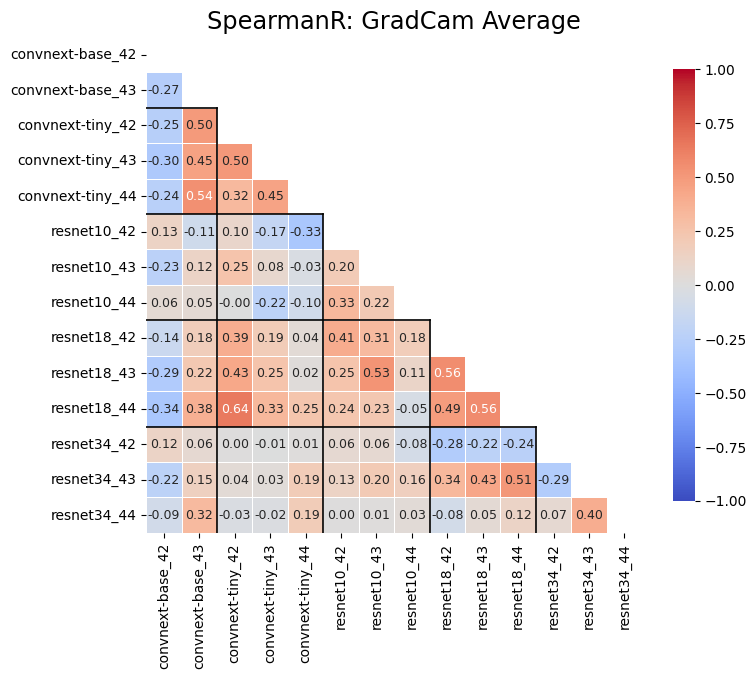

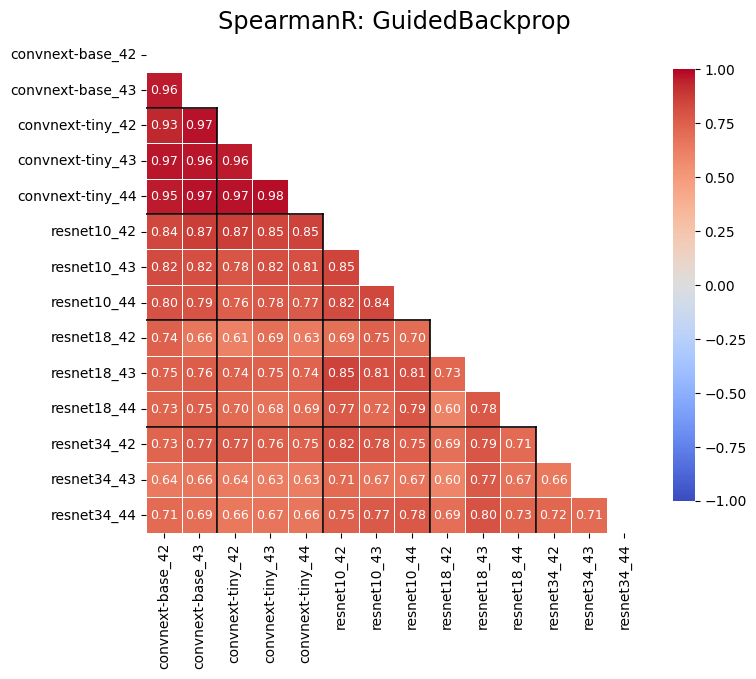

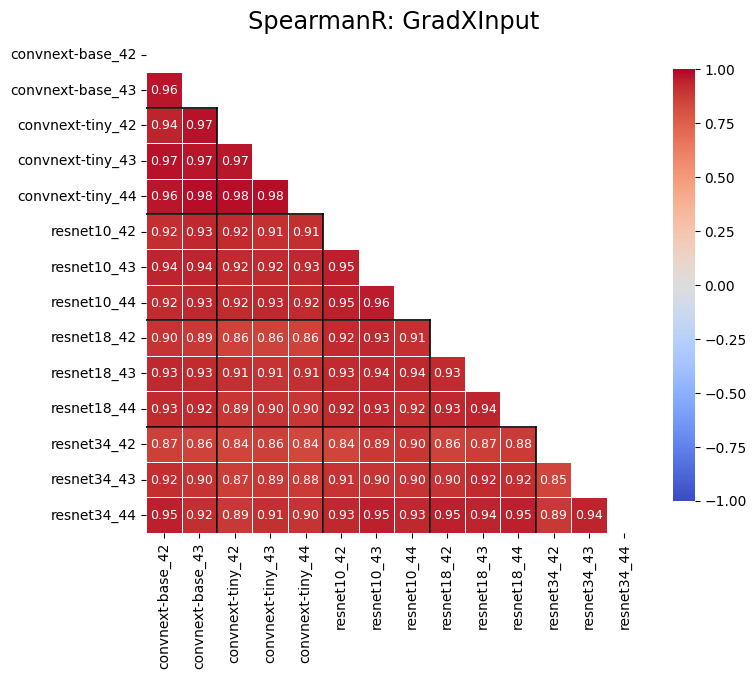

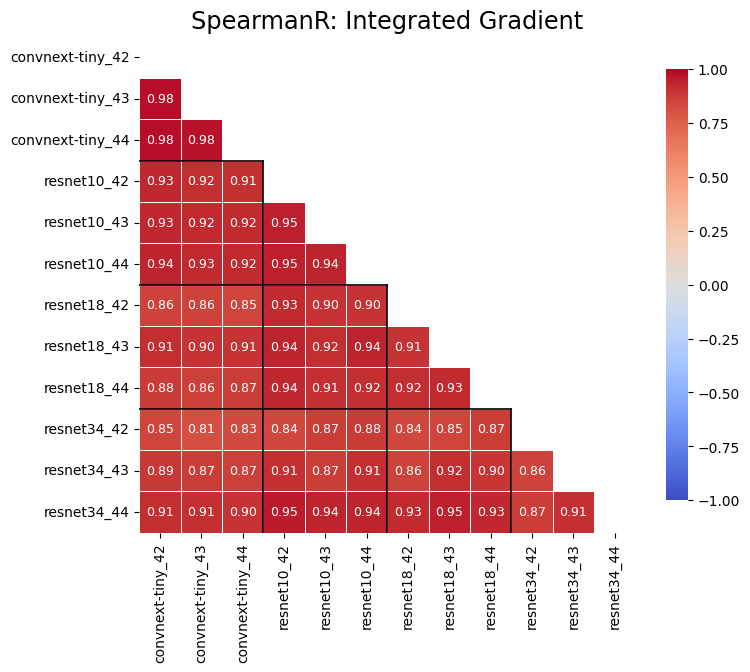

In [4]:
p.plot_corr(corr=gavg_corr, sub_cat="GradCam Average")
p.plot_corr(corr=gbp_corr, sub_cat="GuidedBackprop")
p.plot_corr(corr=gi_corr, sub_cat="GradXInput")
p.plot_corr(corr=ig_corr, sub_cat="Integrated Gradient")

## 2. Variability Across Models (fixed Model, different XAI Method)

/home/1pha/.conda/envs/age/lib/python3.10/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


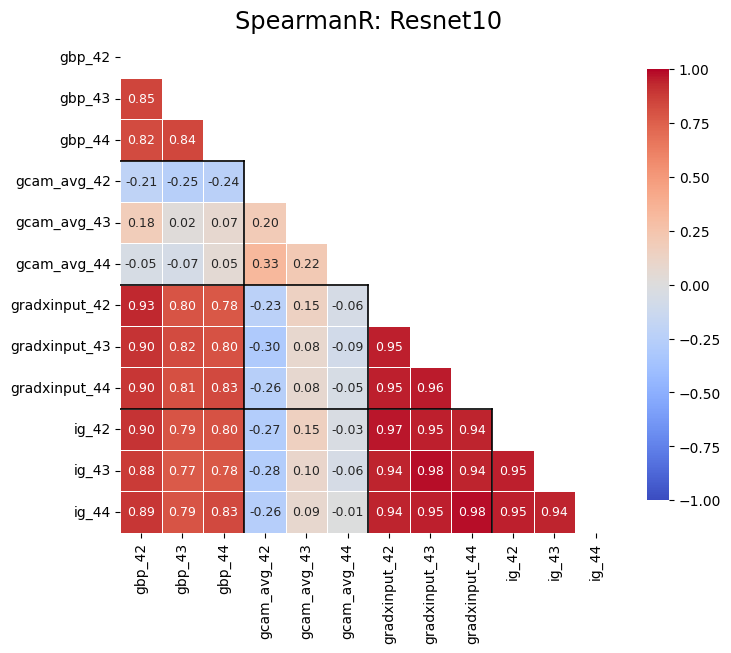

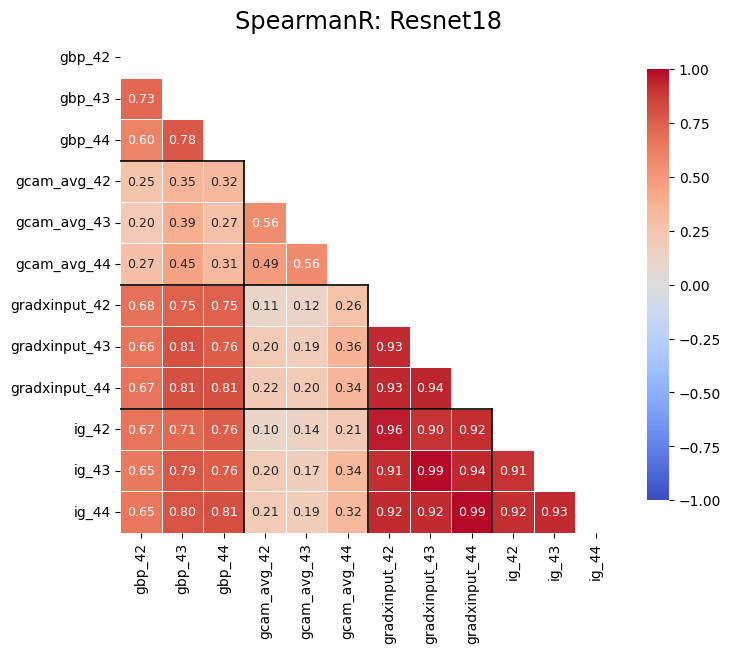

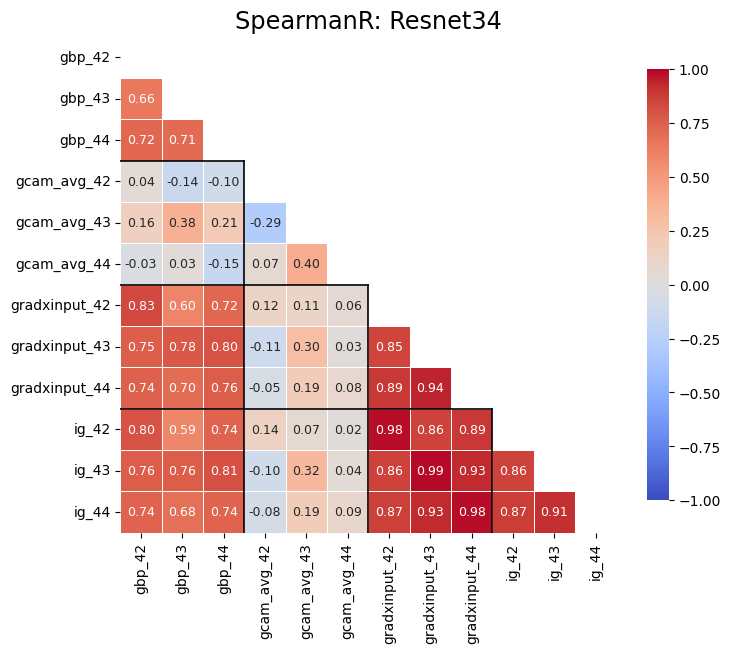

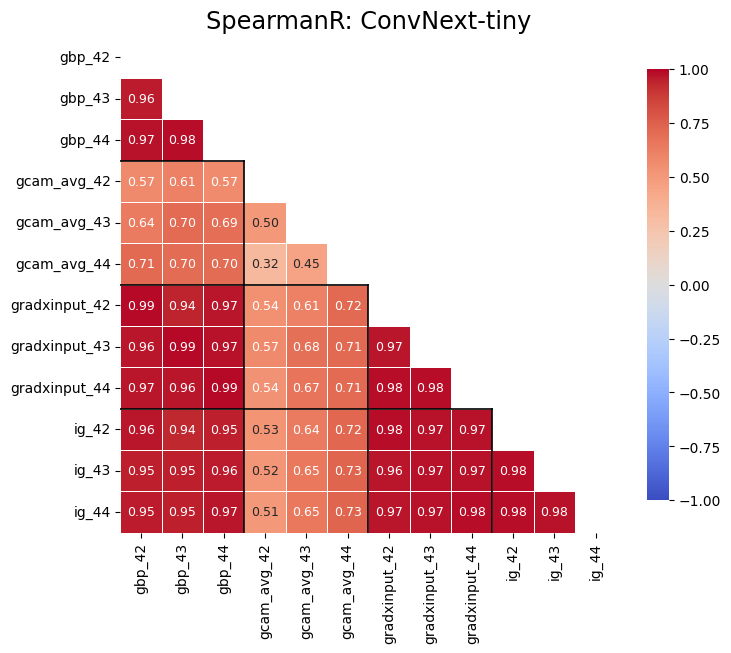

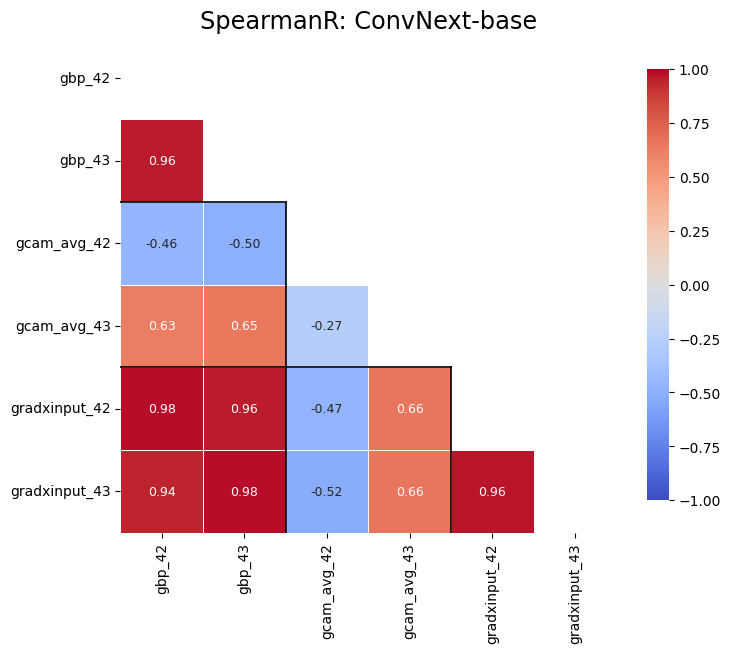

In [5]:
xai_methods = ["gbp", "gcam_avg", "gradxinput", "ig"]
weights_avgs_resnet10 = [wp.WeightAvg(model_name="resnet10", xai_method=xai_method) for xai_method in xai_methods]
resnet10_corr, resnet10_pval = s.spearmanr_permutation(weights_avgs_resnet10, naming="xai")
p.plot_corr(corr=resnet10_corr, sub_cat="Resnet10")

weights_avgs_resnet18 = [wp.WeightAvg(model_name="resnet18", xai_method=xai_method) for xai_method in xai_methods]
resnet18_corr, resnet18_pval = s.spearmanr_permutation(weights_avgs_resnet18, naming="xai")
p.plot_corr(corr=resnet18_corr, sub_cat="Resnet18")

weights_avgs_resnet34 = [wp.WeightAvg(model_name="resnet34", xai_method=xai_method) for xai_method in xai_methods]
resnet34_corr, resnet34_pval = s.spearmanr_permutation(weights_avgs_resnet34, naming="xai")
p.plot_corr(corr=resnet34_corr, sub_cat="Resnet34")

weights_avgs_convnext_tiny = [wp.WeightAvg(model_name="convnext-tiny", xai_method=xai_method) for xai_method in xai_methods]
convnext_tiny_corr, convnext_tiny_pval = s.spearmanr_permutation(weights_avgs_convnext_tiny, naming="xai")
p.plot_corr(corr=convnext_tiny_corr, sub_cat="ConvNext-tiny")

weights_avgs_convnext_base = [wp.WeightAvg(model_name="convnext-base", xai_method=xai_method, seeds=[42, 43]) for xai_method in xai_methods[:-1]]
convnext_base_corr, convnext_base_pval = s.spearmanr_permutation(weights_avgs_convnext_base, naming="xai")
p.plot_corr(corr=convnext_base_corr, sub_cat="ConvNext-base")

## 3. Comparisons against Conventional Methods (Fastsurfer Segmentation, VBM analysis)

In [6]:
meta_dicts = m.load_metadata()

In [7]:
gcam_avg_meta_corrs, pvals = s.spearmanr_vs(weight_avgs=weight_avgs_gcamavg, meta_dicts=meta_dicts)
ig_meta_corrs, pvals = s.spearmanr_vs(weight_avgs=weight_avgs_ig, meta_dicts=meta_dicts)
gi_meta_corrs, pvals = s.spearmanr_vs(weight_avgs=weight_avgs_gi, meta_dicts=meta_dicts)
gbp_meta_corrs, pvals = s.spearmanr_vs(weight_avgs=weight_avgs_gbp, meta_dicts=meta_dicts)

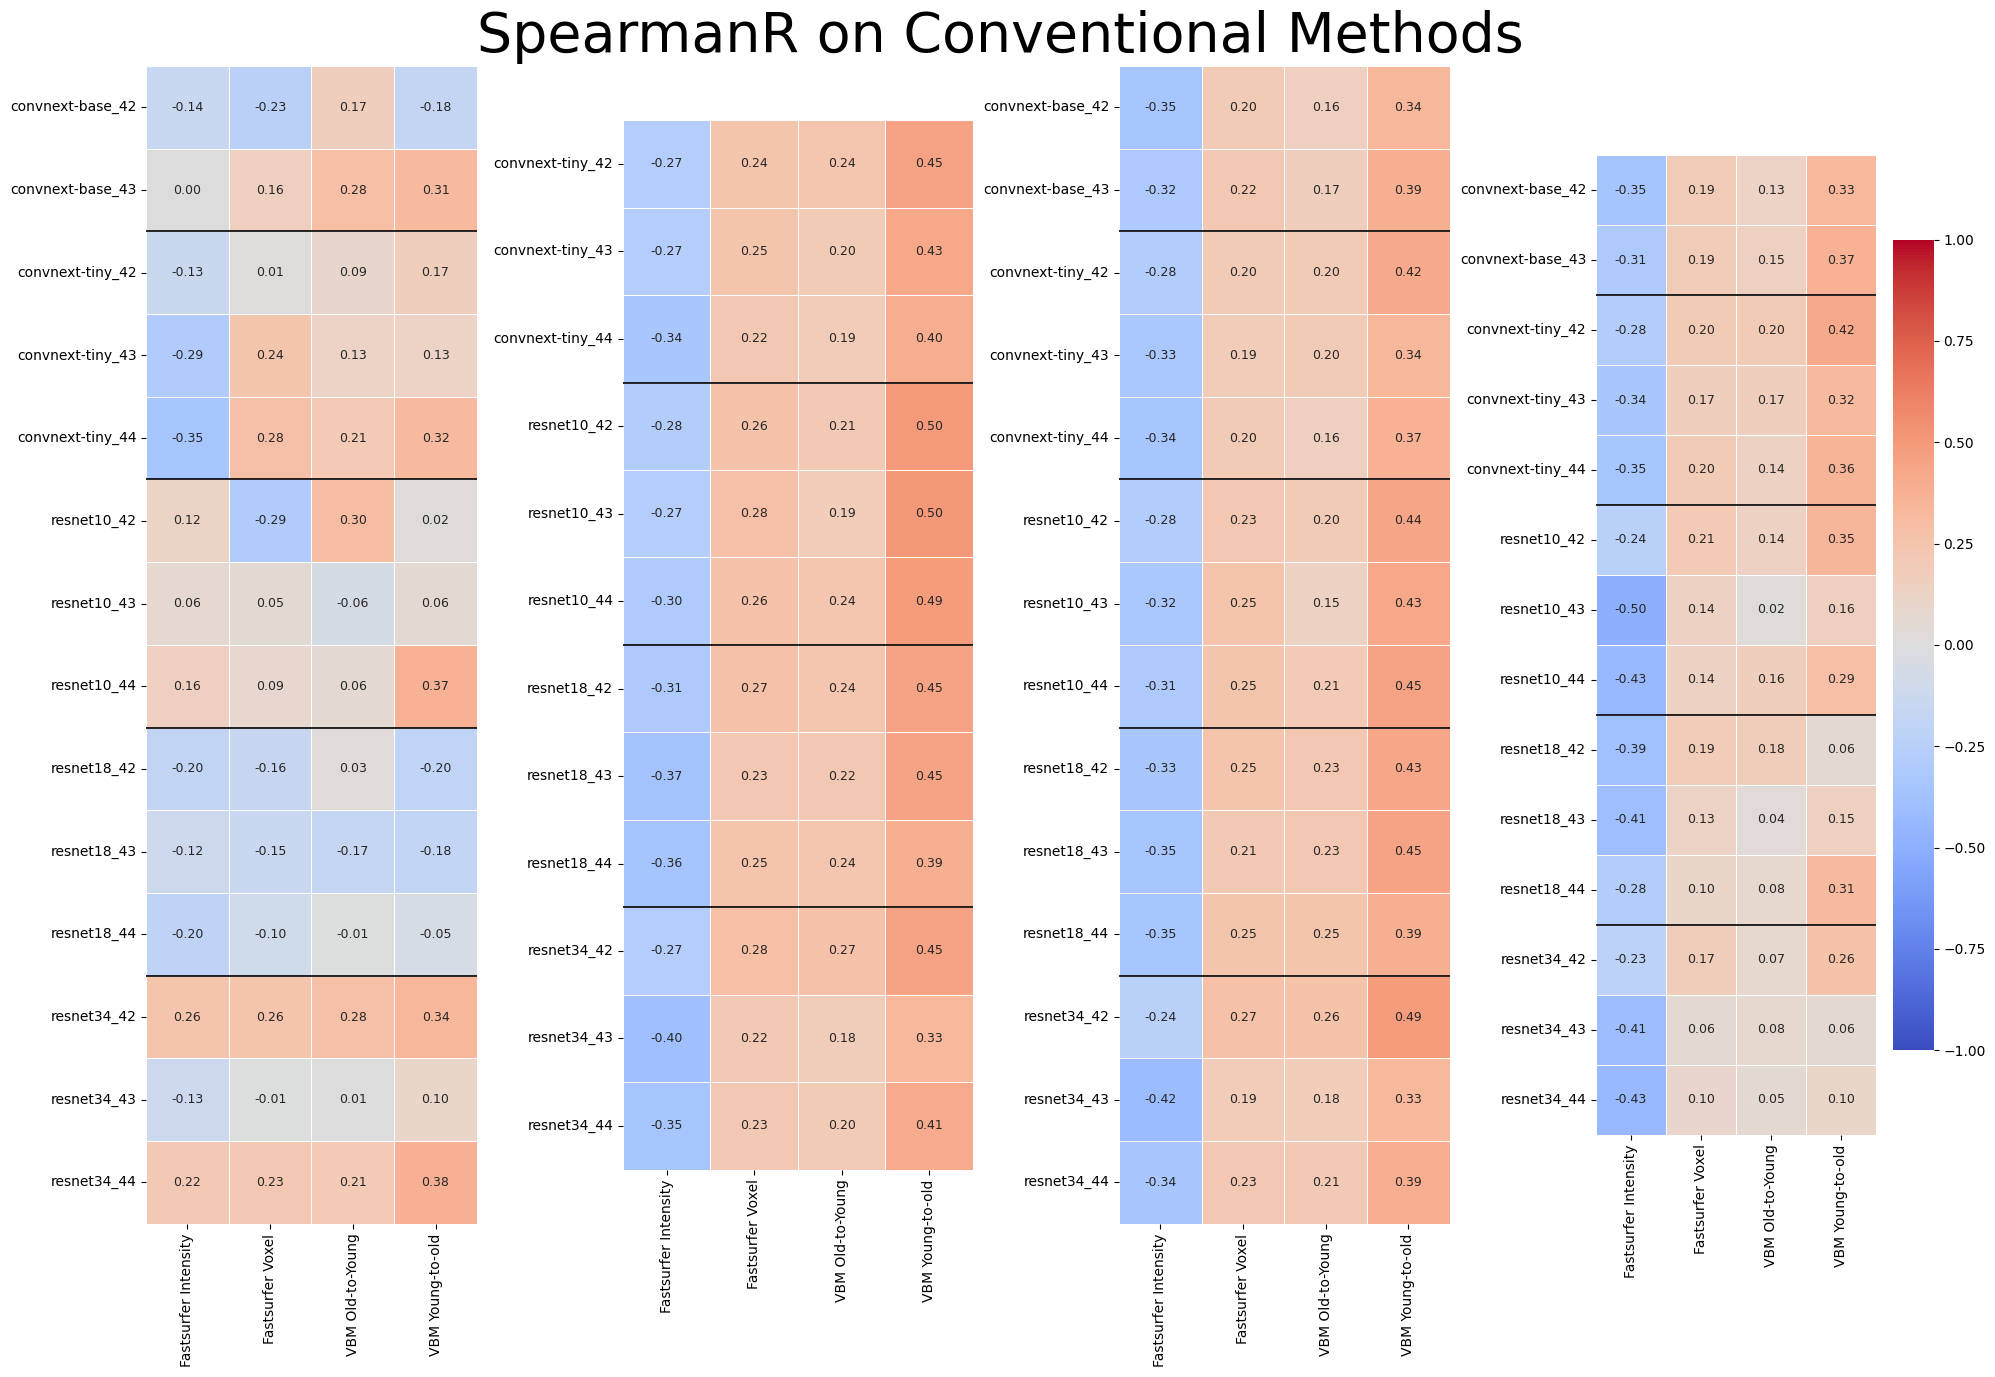

In [10]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 14))

plot_kwargs = dict(use_title=False)
p.plot_corr(gcam_avg_meta_corrs, hide_triu=False, ax=ax[0], use_cbar=False, use_title=False)
p.plot_corr(ig_meta_corrs, hide_triu=False, ax=ax[1], use_cbar=False, use_title=False)
p.plot_corr(gi_meta_corrs, hide_triu=False, ax=ax[2], use_cbar=False, use_title=False)
p.plot_corr(gbp_meta_corrs, hide_triu=False, ax=ax[3], use_cbar=True, use_title=False)
fig.suptitle("SpearmanR on Conventional Methods", size=35)
fig.tight_layout()